# Time between subsequent blocks

What is the distribution of time between subsequent blocks for a user who receives a sitewide, non-indefinite block?

In [3]:
from wmfdata import hive

%load_ext rpy2.ipython

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [4]:
%%R
library(ggplot2);

In [6]:
## This can be answered with a Hive query of the mediawiki_user_history table to calculate
## the time between block events? What we need to do is look for unblock events with an end
## timestamp that is not NULL. Then calculate the time between the start and end timestamps.

time_between_blocks = hive.run('''
SELECT user_id, start_timestamp,
unix_timestamp(end_timestamp, "yyyy-MM-dd HH:mm:ss.0") - 
    unix_timestamp(start_timestamp, "yyyy-MM-dd HH:mm:ss.0") AS time_to_next_block
FROM wmf.mediawiki_user_history
WHERE snapshot= "2018-11"
AND wiki_db = "enwiki"
AND caused_by_event_type = "alterblocks"
AND inferred_from = "unblock"
AND end_timestamp IS NOT NULL
''')

In [7]:
time_between_blocks['time_in_days'] = time_between_blocks['time_to_next_block'] / (60*60*24)

time_between_blocks.describe()

,user_id,time_to_next_block,time_in_days
count,3.572600e+04,3.572600e+04,35726.000000
mean,1.039436e+07,2.039796e+07,236.087492
std,9.794242e+06,5.725646e+07,662.690529
min,2.400000e+01,0.000000e+00,0.000000
25%,1.923743e+06,2.745302e+05,3.177433
50%,6.999039e+06,1.752458e+06,20.283084
75%,1.713791e+07,1.150598e+07,133.171108
max,3.523701e+07,1.976391e+09,22874.890579


In [8]:
time_between_blocks.loc[time_between_blocks['time_in_days'] < 365].describe()

,user_id,time_to_next_block,time_in_days
count,3.072000e+04,3.072000e+04,30720.000000
mean,1.099242e+07,4.219438e+06,48.836088
std,1.005017e+07,6.673955e+06,77.244854
min,9.800000e+01,0.000000e+00,0.000000
25%,2.147636e+06,2.042412e+05,2.363903
50%,7.573506e+06,1.047195e+06,12.120313
75%,1.829967e+07,4.961088e+06,57.420003
max,3.523701e+07,3.153243e+07,364.958727


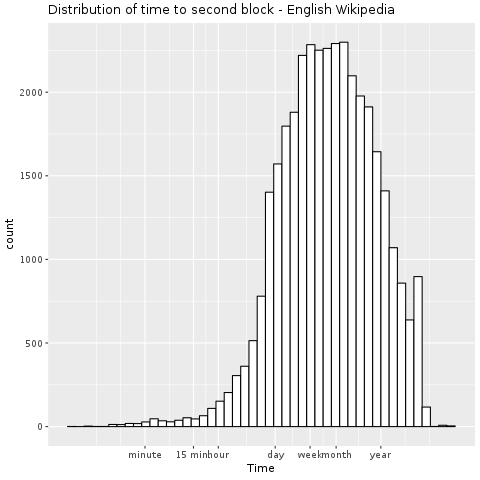

In [11]:
%%R -i time_between_blocks

enwiki_g = ggplot(time_between_blocks,
       aes(x=as.numeric(time_to_next_block))) + 
  geom_histogram(binwidth = 0.2, colour="black", fill='white') +
  ggtitle("Distribution of time to second block - English Wikipedia") +
  scale_x_log10(
    "Time",
    breaks=c(60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
    labels=c("minute", "15 min.", "hour", "day", "week", "month", "year"));
ggsave("graphs/enwiki_time_to_next_block.png",
       plot = enwiki_g, width = 20, height = 20, units = "cm", dpi = "screen");
enwiki_g;

In [12]:
## Also calculate this for itwiki, where partial blocks will be deployed.

itwiki_time_between_blocks = hive.run('''
SELECT user_id, start_timestamp,
unix_timestamp(end_timestamp, "yyyy-MM-dd HH:mm:ss.0") - 
    unix_timestamp(start_timestamp, "yyyy-MM-dd HH:mm:ss.0") AS time_to_next_block
FROM wmf.mediawiki_user_history
WHERE snapshot= "2018-11"
AND wiki_db = "itwiki"
AND caused_by_event_type = "alterblocks"
AND inferred_from = "unblock"
AND end_timestamp IS NOT NULL
''')

In [13]:
itwiki_time_between_blocks['time_in_days'] = itwiki_time_between_blocks['time_to_next_block'] / (60*60*24)
itwiki_time_between_blocks.loc[itwiki_time_between_blocks['time_in_days'] < 365].describe()

,user_id,time_to_next_block,time_in_days
count,4.332000e+03,4.332000e+03,4332.000000
mean,6.793436e+05,3.622112e+06,41.922597
std,4.862537e+05,6.517112e+06,75.429534
min,9.000000e+00,1.000000e+00,0.000012
25%,2.559410e+05,7.832325e+04,0.906519
50%,5.867705e+05,5.387685e+05,6.235747
75%,1.043044e+06,3.708926e+06,42.927384
max,1.755208e+06,3.153478e+07,364.985903


In [14]:
itwiki_time_between_blocks.describe()

,user_id,time_to_next_block,time_in_days
count,5.244000e+03,5.244000e+03,5244.000000
mean,6.270404e+05,2.338388e+07,270.646755
std,4.756760e+05,5.450357e+07,630.828307
min,9.000000e+00,1.000000e+00,0.000012
25%,2.173452e+05,1.241440e+05,1.436852
50%,5.271225e+05,1.158266e+06,13.405851
75%,9.704400e+05,1.397033e+07,161.693628
max,1.755208e+06,3.762364e+08,4354.587986


/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


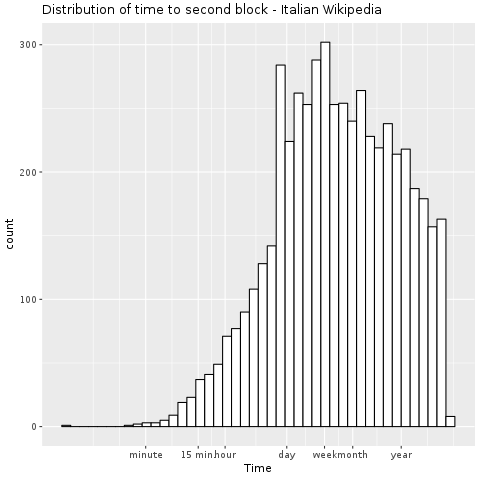

In [15]:
%%R -i itwiki_time_between_blocks

g = ggplot(itwiki_time_between_blocks,
       aes(x=as.numeric(time_to_next_block))) + 
  geom_histogram(binwidth = 0.2, colour="black", fill='white') +
  ggtitle("Distribution of time to second block - Italian Wikipedia") +
  scale_x_log10(
    "Time",
    breaks=c(60, 15*60, 60*60, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
    labels=c("minute", "15 min.", "hour", "day", "week", "month", "year"));
ggsave("graphs/itwiki_time_to_next_block.png",
       plot = g, width = 20, height = 20, units = "cm", dpi = "screen");
g;